<a href="https://colab.research.google.com/github/ngupta23/ds7337_nlp/blob/master/Exams/finals/NGupta_question2_USE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [1]:
from typing import List, Tuple
from time import time
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_hub as hub

In [3]:
tf.__version__

'2.3.0'

# Get Data

In [4]:
!rm -rf ./*

In [5]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

URL transformed to HTTPS due to an HSTS policy
--2020-08-08 14:45:09--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  62.6MB/s    in 1.2s    

2020-08-08 14:45:11 (62.6 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [6]:
!unzip trainingandtestdata.zip

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [7]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
data = data[[5, 0]]
data.head()

,5,0
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [10]:
data = data.rename(columns={5:'text', 0:'sentiment'})
data.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [11]:
data['text'] = data['text'].str.strip()
data.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


# Prepare Labels

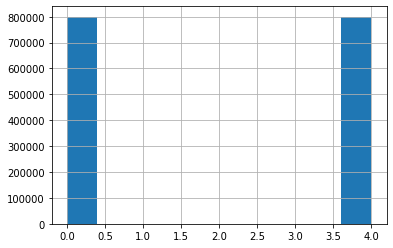

In [12]:
data['sentiment'].hist()

In [13]:
data['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [14]:
data.loc[data['sentiment'] == 4, 'sentiment'] = 1

In [15]:
data['sentiment'].value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

In [16]:
data.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [17]:
NUM_CLASSES = len(set(data['sentiment']))
NUM_CLASSES

2

# Shuffle Data

In [18]:
data = data.sample(frac=1).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   text       1600000 non-null  object
 1   sentiment  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


# Max Sequence Length

The number of characters reaches a max length of 374, but that might be an exception. For Universal Sentence Encoder (USE), we can possibly limit this to a smaller number based on the histogram of character lengths. 

The number of words reaches a maximum value of 64. For RNN variants, again, we can limit this to a smaller number based on the distribution of the number of words as shown below

In [19]:
data['charlen'] = data['text'].str.len()
data['wordlen'] = data['text'].str.split().str.len()
data.head()

,text,sentiment,charlen,wordlen
0,@NickSwisher I bet you hit a homerun tomorrow!...,1,57,10
1,@KCKORGEOUS wtf happened to you?!?! today was...,0,138,23
2,@Shannonhochkins nah there not but shaun said...,0,134,26
3,@DonnieWahlberg Sexy Sexy Pic! Love it!,1,40,6
4,@erinnxily PS: I'm driving to school but I'm n...,0,126,24


In [20]:
print('Maximum review length (words): {}'.format(data['wordlen'].max()))
print('Minimum review length (words): {}'.format(data['wordlen'].min()))
print('Maximum review length (chars): {}'.format(data['charlen'].max()))
print('Minimum review length (chars): {}'.format(data['charlen'].min()))

Maximum review length (words): 64
Minimum review length (words): 1
Maximum review length (chars): 373
Minimum review length (chars): 3


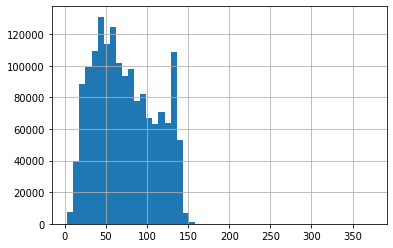

In [21]:
data['charlen'].hist(bins=50)

In [22]:
# Keep a large percentage of reviews completely and chop of the remainig reviews off.
time_steps_USE = int(np.quantile(data['charlen'],0.975))
time_steps_USE

137

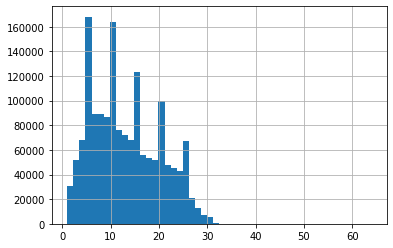

In [23]:
data['wordlen'].hist(bins=50)

In [24]:
# Keep a large percentage of reviews completely and chop of the remainig reviews off.
time_steps_RNN = int(np.quantile(data['wordlen'],0.975))
time_steps_RNN

27

# Train and Validation Split

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    data['text'].values.astype('U'),
    data['sentiment'].values.astype('int32'),
    test_size=0.5,
    random_state=42
)

print(f"Number of samples: X_train: {len(X_train)}, y_train: {len(y_train)}")
print(f"Number of samples: X_test: {len(X_val)}, y_test: {len(y_val)}")

Number of samples: X_train: 800000, y_train: 800000
Number of samples: X_test: 800000, y_test: 800000


In [26]:
# Checking split --> both test and train contain roughly the same % of observation from each class
for i in range(NUM_CLASSES):
  print(sum(y_train == i)/len(y_train), sum(y_val == i)/len(y_val))

0.499655 0.500345
0.500345 0.499655


# Training

In [27]:
def plot_metrics(history: tf.python.keras.callbacks.History, metrics: List[str] = ['loss'], figsize: Tuple[int, int] = (10,4), title: str = "Train/Test Curves", titlefontsize:int = 14):
  """
  This functin will plot the metrics for the model
  :param history: The history object obtained from the fit function.
  :type history: tf.python.keras.callbacks.History
  :param metrics: What metrics to plot for the model (Default = ['loss'])
  :type metrics: List[str]
  :param figsize: Figure size to be used for plotting (Default = (10,4))
  :type figsize: Tuple(int,int)
  """
  num_plots = len(metrics)
  fig, axes = plt.subplots(int(num_plots/2), 2, figsize=figsize)

  for num, metric in enumerate(metrics):
    # summarize history for metric
    if num <= 2:
      axes[num%2].plot(history.history[metric])
      axes[num%2].plot(history.history['val_' + metric])
      axes[num%2].set_title('Model ' + metric)
      axes[num%2].set(xlabel='Epoch', ylabel=metric)
      axes[num%2].legend(['train', 'val'], loc='best')    
    else:
      axes[floor(num/2), num%2].plot(history.history[metric])
      axes[floor(num/2), num%2].plot(history.history['val_' + metric])
      axes[floor(num/2), num%2].set_title('Model ' + metric)
      axes[floor(num/2), num%2].set(xlabel='Epoch', ylabel=metric)
      axes[floor(num/2), num%2].legend(['train', 'val'], loc='best')

  plt.suptitle(title, fontsize=titlefontsize, y=1.02)    
  plt.tight_layout()
  _ = plt.show

In [28]:
X_train[0].shape

()

In [29]:
set(data['sentiment'])

{0, 1}

In [30]:
USE = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

In [31]:
# This is useful to debug the issues with input shape: https://github.com/tensorflow/hub/issues/526
input_text = Input(shape=(), name='sentence',dtype=tf.string)
embedding = USE(input_text)
# dense1 = Dense(256, activation='relu')(embedding)
# dropout1 = Dropout(0.2)(dense1)
# dense2 = Dense(100, activation='relu')(dropout1)
dense2 = Dense(100, activation='relu')(embedding)
dropout2 = Dropout(0.2)(dense2)
pred = Dense(NUM_CLASSES, activation='softmax')(dropout2)
model = Model(inputs=[input_text], outputs=pred)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence (InputLayer)        [(None,)]                 0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 256,849,326
Trainable params: 51,502
Non-trainable params: 256,797,824
_________________________________________________________________


In [32]:
model.predict(tf.convert_to_tensor(["the cat is on the mat", "dogs are in the fog"]))

array([[0.4718952 , 0.5281048 ],
       [0.44230822, 0.5576918 ]], dtype=float32)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
# If validation error does not improve for 10 epochs, then terminate the training
es = EarlyStopping(min_delta=0,patience=3)

from tensorflow.keras.callbacks import ModelCheckpoint
# add a checkpoint to save the lowest validation loss
filepath = '.'
checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, 
    save_best_only=True, save_weights_only=False, 
    mode='auto', save_frequency=1
    )

In [34]:
BATCH_SIZE = 4096
EPOCHS = 10
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[es, checkpoint]    
    )

Epoch 1/10
196/196 [==============================] - ETA: 0s - loss: 0.4924 - accuracy: 0.7676
Epoch 00001: val_loss improved from inf to 0.45921, saving model to .
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


196/196 [==============================] - 93s 472ms/step - loss: 0.4924 - accuracy: 0.7676 - val_loss: 0.4592 - val_accuracy: 0.7814
Epoch 2/10
196/196 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.7847
Epoch 00002: val_loss improved from 0.45921 to 0.44934, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


196/196 [==============================] - 90s 460ms/step - loss: 0.4546 - accuracy: 0.7847 - val_loss: 0.4493 - val_accuracy: 0.7869
Epoch 3/10
196/196 [==============================] - ETA: 0s - loss: 0.4464 - accuracy: 0.7897
Epoch 00003: val_loss improved from 0.44934 to 0.44247, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


196/196 [==============================] - 91s 464ms/step - loss: 0.4464 - accuracy: 0.7897 - val_loss: 0.4425 - val_accuracy: 0.7912
Epoch 4/10
196/196 [==============================] - ETA: 0s - loss: 0.4405 - accuracy: 0.7934
Epoch 00004: val_loss improved from 0.44247 to 0.43772, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


196/196 [==============================] - 92s 468ms/step - loss: 0.4405 - accuracy: 0.7934 - val_loss: 0.4377 - val_accuracy: 0.7939
Epoch 5/10
196/196 [==============================] - ETA: 0s - loss: 0.4361 - accuracy: 0.7962
Epoch 00005: val_loss improved from 0.43772 to 0.43454, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


196/196 [==============================] - 92s 467ms/step - loss: 0.4361 - accuracy: 0.7962 - val_loss: 0.4345 - val_accuracy: 0.7959
Epoch 6/10
196/196 [==============================] - ETA: 0s - loss: 0.4329 - accuracy: 0.7982
Epoch 00006: val_loss improved from 0.43454 to 0.43200, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


196/196 [==============================] - 92s 469ms/step - loss: 0.4329 - accuracy: 0.7982 - val_loss: 0.4320 - val_accuracy: 0.7972
Epoch 7/10
196/196 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.7997
Epoch 00007: val_loss improved from 0.43200 to 0.43032, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


196/196 [==============================] - 91s 466ms/step - loss: 0.4305 - accuracy: 0.7997 - val_loss: 0.4303 - val_accuracy: 0.7985
Epoch 8/10
196/196 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.8006
Epoch 00008: val_loss improved from 0.43032 to 0.42958, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


196/196 [==============================] - 92s 470ms/step - loss: 0.4286 - accuracy: 0.8006 - val_loss: 0.4296 - val_accuracy: 0.7988
Epoch 9/10
196/196 [==============================] - ETA: 0s - loss: 0.4270 - accuracy: 0.8018
Epoch 00009: val_loss improved from 0.42958 to 0.42786, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


196/196 [==============================] - 92s 469ms/step - loss: 0.4270 - accuracy: 0.8018 - val_loss: 0.4279 - val_accuracy: 0.8000
Epoch 10/10
196/196 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.8024
Epoch 00010: val_loss improved from 0.42786 to 0.42709, saving model to .
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


196/196 [==============================] - 92s 469ms/step - loss: 0.4255 - accuracy: 0.8024 - val_loss: 0.4271 - val_accuracy: 0.8003


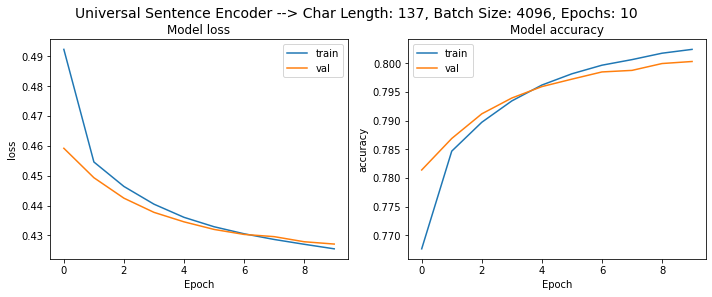

In [35]:
plot_metrics(
    history,
    metrics=['loss', 'accuracy'],
    title = f"Universal Sentence Encoder --> Char Length: {time_steps_USE}, Batch Size: {BATCH_SIZE}, Epochs: {EPOCHS}")

# Predictions

In [36]:
predictions = model.predict(X_val)
predictions[:5]

array([[0.00614592, 0.99385405],
       [0.959502  , 0.04049803],
       [0.06106586, 0.9389341 ],
       [0.8333014 , 0.16669858],
       [0.22459829, 0.7754017 ]], dtype=float32)

In [37]:
predictions_max = tf.math.argmax(predictions, axis=1)
predictions_max[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 1, 0, 1])>

In [38]:
y_val[0:5]

array([1, 0, 1, 0, 1], dtype=int32)

In [39]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_val, predictions_max)
m.result().numpy()

0.80031127

In [40]:
predictions

array([[0.00614592, 0.99385405],
       [0.959502  , 0.04049803],
       [0.06106586, 0.9389341 ],
       ...,
       [0.01872614, 0.9812739 ],
       [0.17355745, 0.8264426 ],
       [0.43124503, 0.568755  ]], dtype=float32)